In [1]:
%clear
import tensorflow as tf
import numpy as np
import argparse
import socket
import importlib
import time
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

import scipy.misc
import sys
BASE_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(BASE_DIR) +'/pointnet2-master'
sys.path.append(BASE_DIR)
sys.path.append(ROOT_DIR)
print('BASE_DIR =' ,BASE_DIR)
print('ROOT_DIR =' ,ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
import provider
import modelnet_dataset
import modelnet_h5_dataset
import my_data_import as chao_data_import

BASE_DIR = /home/chaotang/文档/Try
ROOT_DIR = /home/chaotang/文档/pointnet2-master


MODEL_PATH /home/chaotang/文档/pointnet2-master/log/model.ckpt
cur_batch_data (16, 2048, 3)
cur_batch_label (16,)
Original_pl (16, 2048, 3)


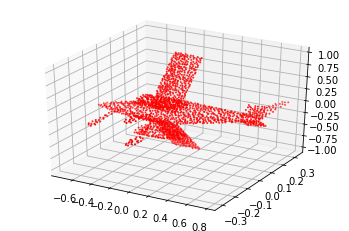

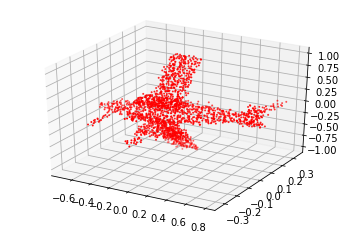

In [2]:
BATCH_SIZE = 16
NUM_POINT = 2048
MODEL_PATH = ROOT_DIR + '/log/model.ckpt'
print('MODEL_PATH',MODEL_PATH)
GPU_INDEX =0
MODEL = importlib.import_module('pointnet2_cls_ssg') # import network module
# This is the Classification Network

test_index = 2
# Make sure batch data is of same size
cur_batch_data = np.zeros((BATCH_SIZE,NUM_POINT,3))
cur_batch_label = np.zeros((BATCH_SIZE), dtype=np.int32)

Original_pl = np.zeros((BATCH_SIZE,NUM_POINT,3))
Noisy_pl = np.zeros((BATCH_SIZE,NUM_POINT,3))

cur_batch_data,cur_batch_label = chao_data_import.get_data()
print('cur_batch_data',cur_batch_data.shape)# The shape of the data set is (16, 1024, 3)
print('cur_batch_label',cur_batch_label.shape)

Original_pl[:] = cur_batch_data[:]# 干净的点云
Original_label = np.zeros(cur_batch_label.shape)
Original_label[:] = cur_batch_label[:]
print('Original_pl',Original_pl.shape)
chao_data_import.draw_pointcloud(Original_pl[test_index])
Noisy_pl[test_index,...] = Original_pl[test_index,...] + 0.0125 * np.random.normal(size = (NUM_POINT,3))# Noisy的点云
chao_data_import.draw_pointcloud(Noisy_pl[test_index])

# Try to get the weight of each point
Original_pl:原始的干净点云  

Noisy_pl : 有噪音的点云

In [23]:
# Utility function 
def random_plusminus(shape):
    unimatrix = np.zeros(shape)
    for i in range(shape[0]):
        unimatrix[i] = choice([-1,0,1])
    return unimatri
# 错误点1： 首先这个地方就不应该这样移动，应该是选取均匀的方向移动
# 设立27种位移情况，分成两个batch输入到网络中，这样就构成了空间均匀且移动稳定，score储存这27种情况
# 分成两个batch丢入神经网络中

def batchdisplace():
    batch = np.zeros((32,3))
    index = 0
    for x_i in range(-1,2):
        for y_i in range(-1,2):
            for z_i in range(-1,2):
                batch[index] = (x_i,y_i,z_i)
                norm = np.linalg.norm(batch[index])
                batch[index] /= norm
                index +=1
    batch[np.isnan(batch)] = 0
    return batch

# Generate mask from clean point cloud

In [26]:
tf.reset_default_graph()
##############################
#### Redefine the Graph#######
##############################
num_votes = 1
is_training = False

is_training_pl = tf.placeholder(tf.bool, shape=())
# def placeholder_inputs(batch_size, num_point):
pointclouds_pl = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_POINT, 3)) # shape = (16,1024,3)
labels_pl = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
pred,end_points = MODEL.get_model(pointclouds_pl, is_training_pl)

saver = tf.train.Saver()

with tf.device('/gpu:0'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
with tf.Session() as sess:
    saver.restore(sess,MODEL_PATH)
    print('Model restored!!!!!')
    print('Calculating....')
    # Score variation for each point (2048,27)
    # 因为取值变化有27种方向
    score = np.zeros((NUM_POINT,27))
    batch_displacement = batchdisplace()
    
    for each_p in range(NUM_POINT):
        Temp_batch = np.zeros(Original_pl.shape)
        Temp_batch2 = np.zeros(Original_pl.shape)
        
        for i in range(BATCH_SIZE):
            # Count BATCH_SIZE times and Get the average for this point
            ##############################################################
            Temp_batch[i]=Original_pl[test_index]
            Temp_batch2[i] = Original_pl[test_index]
            ##############################################################
        Temp_batch[:,each_p,:] += 0.0125 * batch_displacement[0:BATCH_SIZE]
        Temp_batch2[:,each_p,:]+= 0.0125 * batch_displacement[BATCH_SIZE:2*BATCH_SIZE]
        
        feed = {pointclouds_pl:Temp_batch,is_training_pl:is_training}
        feed2 = {pointclouds_pl:Temp_batch2,is_training_pl:is_training}
        
        pred_val ,_ = sess.run([pred,end_points],feed_dict = feed)
        pred_val_2 ,_ = sess.run([pred,end_points],feed_dict = feed2)
        
        score[each_p,0:BATCH_SIZE] = pred_val[:,0]
        score[each_p,BATCH_SIZE:27] = pred_val_2[0:11,0]
    print('The score for one image has been generated')

INFO:tensorflow:Restoring parameters from /home/chaotang/文档/pointnet2-master/log/model.ckpt
Model restored!!!!!
Calculating....


/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


The score for one image has been generated


In [34]:
tf.reset_default_graph()
##############################
#### Redefine the Graph#######
##############################
num_votes = 1
is_training = False

is_training_pl = tf.placeholder(tf.bool, shape=())
# def placeholder_inputs(batch_size, num_point):
pointclouds_pl = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_POINT, 3)) # shape = (16,1024,3)
labels_pl = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
pred,end_points = MODEL.get_model(pointclouds_pl, is_training_pl)

saver = tf.train.Saver()

with tf.device('/gpu:0'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
with tf.Session() as sess:
    saver.restore(sess,MODEL_PATH)
    print('Model restored!!!!!')
    print('Calculating....')
    # Score variation for each point (2048,27)
    # 因为取值变化有27种方向
    score_noisy = np.zeros((NUM_POINT,27))
    batch_displacement = batchdisplace()
    
    for each_p in range(NUM_POINT):
        Temp_batch = np.zeros(Original_pl.shape)
        Temp_batch2 = np.zeros(Original_pl.shape)
        
        for i in range(BATCH_SIZE):
            # Count BATCH_SIZE times and Get the average for this point
            ##############################################################
            Temp_batch[i]=Noisy_pl[test_index]
            Temp_batch2[i] = Noisy_pl[test_index]
            ##############################################################
        Temp_batch[:,each_p,:] += 0.0125 * batch_displacement[0:BATCH_SIZE]
        Temp_batch2[:,each_p,:]+= 0.0125 * batch_displacement[BATCH_SIZE:2*BATCH_SIZE]
        
        feed = {pointclouds_pl:Temp_batch,is_training_pl:is_training}
        feed2 = {pointclouds_pl:Temp_batch2,is_training_pl:is_training}
        
        pred_val ,_ = sess.run([pred,end_points],feed_dict = feed)
        pred_val_2 ,_ = sess.run([pred,end_points],feed_dict = feed2)
        
        score_noisy[each_p,0:BATCH_SIZE] = pred_val[:,0]
        score_noisy[each_p,BATCH_SIZE:27] = pred_val_2[0:11,0]
    print('The score_noisy for one image has been generated')

INFO:tensorflow:Restoring parameters from /home/chaotang/文档/pointnet2-master/log/model.ckpt
Model restored!!!!!
Calculating....


/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


The score_noisy for one image has been generated


# Try to get the weight of each point
Original_pl:原始的干净点云  

Noisy_pl : 有噪音的点云

(2048, 27)


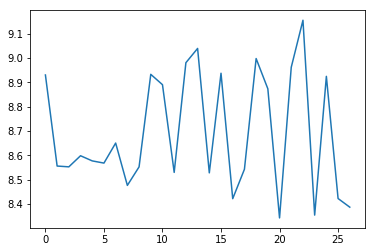

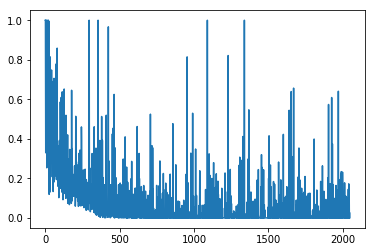

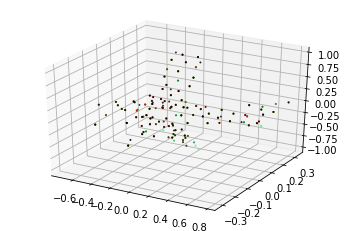

In [64]:
#plt.figure()
#plt.plot(score[3])
###################这个定义sensitivity的方式还有待商榷#####################
print(score.shape)
plt.figure()
plt.plot(score[6])
Smax = np.amax(score,axis = 1)
Smin = np.amin(score,axis = 1)
Sensitivity = Smax - Smin

weight_each_point = np.clip(Sensitivity,0,1)
# weight_each_point/=0.2
plt.figure()
plt.plot(weight_each_point)
############################################################
visual = Original_pl[test_index]
#######################################################
plt.figure()
ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
color = ['palegreen','greenyellow','cyan','darkgreen','red','k']
for i in range(6):
    x,y,z = visual[weight_each_point>0.05 * i][0:100,0],visual[weight_each_point>0.05 * i][0:100,1],visual[weight_each_point>0.05 * i][0:100,2]
    ax.scatter(x,y,z,c = color[i],s = 1)